In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

from subprocess import check_output

In [12]:
train = pd.read_csv('C:/Users/Ax/Desktop/chars/train.csv').fillna(" ")
train = train.dropna(how="any").reset_index(drop=True)

In [13]:
train.head()

,is_duplicate,q1,q2,question1,question2,id
0,1,Q397345,Q538594,L2218 L2568 L0360 L0242 L2218 L0741,L3019 L0104 L0582 L2218 L1861 L1556 L0242,0
1,0,Q193805,Q699273,L2376 L2168 L0050 L1187 L0104 L2432 L0902 L014...,L0156 L2452 L1187 L0104 L2459 L2979 L2613 L0449,1
2,0,Q085471,Q676160,L2323 L1526 L2214 L1132 L2723 L1861 L2249 L050...,L2568 L0971 L1291 L0358 L0037 L2582,2
3,0,Q189314,Q438123,L0018 L2321 L1346 L2432 L0902 L1149 L1980 L187...,L3019 L0104 L1104 L1935 L1683 L2495 L2812,3
4,0,Q267714,Q290126,L2271 L1346 L1389 L2932 L0466 L2218 L1971 L221...,L0050 L1187 L0104 L1683 L2495 L2812 L1588 L255...,4


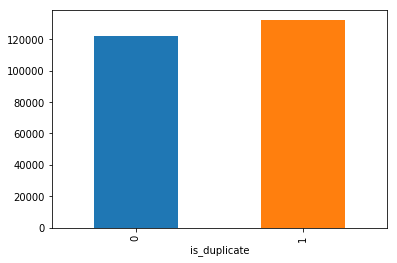

In [14]:
train.groupby("is_duplicate")['id'].count().plot.bar()

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
Bag = CountVectorizer(max_df=0.999, min_df=50, max_features=300, 
                                      analyzer='char', ngram_range=(1,2), 
                                      binary=True, lowercase=True)

In [17]:
Bag.fit(pd.concat((train.question1,train.question2)).unique())

CountVectorizer(analyzer='char', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.999, max_features=300, min_df=50,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
question1 = Bag.transform(train['question1'])
question2 = Bag.transform(train['question2'])

In [19]:
X = -(question1 != question2).astype(int)
y = train['is_duplicate'].values

In [20]:
logisticRegressor = linear_model.LogisticRegression(C=0.1, solver='sag', 
                                                    class_weight={1: 0.472008228977, 0: 1.30905513329})
logisticRegressor.fit(X, y)

LogisticRegression(C=0.1, class_weight={1: 0.472008228977, 0: 1.30905513329},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)

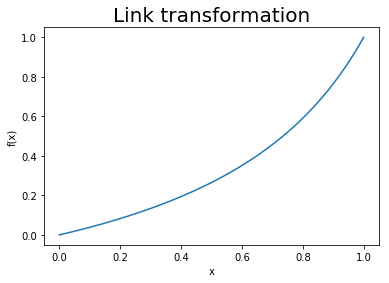

In [21]:
gamma_0 = 1.30905513329
gamma_1 = 0.472008228977
def link_function(x):
    return gamma_1*x/(gamma_1*x + gamma_0*(1 - x))

support = np.linspace(0, 1, 1000)
values = link_function(support)

fig, ax = plt.subplots()
ax.plot(support, values)
ax.set_title('Link transformation', fontsize=20)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
plt.show()

In [32]:
test = pd.read_csv('C:/Users/Ax/Desktop/chars/test.csv')
test.ix[test['question1'].isnull(),['question1','question2']] = ' '
test.ix[test['question2'].isnull(),['question1','question2']] = ' '

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
%%time
test.ix[test['question1'].isnull(),['question1','question2']] = ' '
test.ix[test['question2'].isnull(),['question1','question2']] = ' '

Question1 = Bag.transform(test['question1'])
Question2 = Bag.transform(test['question2'])

X_test = -(Question1 != Question2).astype(int)

seperators= [50000,100000]
testPredictions1 = logisticRegressor.predict_proba(X_test[:seperators[0],:])[:,1]
testPredictions2 = logisticRegressor.predict_proba(X_test[seperators[0]:seperators[1],:])[:,1]
testPredictions3 = logisticRegressor.predict_proba(X_test[seperators[1]:,:])[:,1]
testPredictions = np.hstack((testPredictions1,testPredictions2,testPredictions3))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Wall time: 13.3 s


In [36]:
submissionName = 'quora_submission'

submission = pd.DataFrame()
submission['test_id'] = test['test_id']
submission['is_duplicate'] = testPredictions
submission.to_csv(submissionName + '.csv', index=False)

In [61]:
import math
import pandas as pd
submissionLSTM = pd.read_csv('submissionLSTM.csv')
submission = pd.DataFrame()
submission['y_pre'] = submissionLSTM['y_pre']
for index,row in submission.iterrows():
    row["y_pre"]= math.floor(row["y_pre"]+0.5)
submission.to_csv('submissionlstmlstm.csv', index=False)

In [59]:

inp = [{'c1':10, 'c2':100}, {'c1':11,'c2':110}, {'c1':12,'c2':120}]
df = pd.DataFrame(inp)
print(df )
for index, row in df.iterrows():
    print (row["c1"], row["c2"])

   c1   c2
0  10  100
1  11  110
2  12  120
10 100
11 110
12 120
